# Metropolis sampling

In this notebook we analyse the results from VMC calculations on a spherical harmonic oscillator using brute force Metropolis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tqdm

from vmc.interface import PyHarmonicOscillator, PyMetropolisAlgorithm, \
    PySimpleGaussian, PySimpleGaussianNumerical, PySampler, \
    PyImportanceMetropolis

from IPython.core.pylabtools import figsize
from IPython.core.display import display

In [2]:
sns.set(color_codes=True)
#figsize(14, 10)

We use natural units with $m = \hbar = c = 1$. We also restrict our views to $\omega = 1$ in this analysis.

In [3]:
mass = 1.0
omega = 1.0
hbar = 1.0

step_length = 2.0

h = 1e-7

## The one dimensional spherical harmonic oscillator

Starting with the simplest case we look at the one dimensional spherical harmonic oscillator.

\begin{align}
    \Psi_T(\mathbf{x}) &= \prod_{i = 1}^N\exp(-\alpha x_i).
\end{align}

We wish to compare the CPU time of the analytical scheme, i.e., an analytical expression for the Laplcian and hence the local energy, versus a central difference scheme of second order.

We know that the exact ground state energy for the one dimensional spherical harmonic oscillator can be found at $\alpha = 0.5$. By restricting our view to the region $\alpha \in [0.1, 0.7]$ we should observe a trend where the average energy goes towards a minimum at $\alpha = 0.5$ and increases on both sides.

In [4]:
alpha_min = 0.3
alpha_max = 0.9
num_alphas = 31

alphas = np.linspace(
    alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)

In [5]:
num_particles = 1
num_dimensions = 1

#num_samples = int(num_particles * 12000)
num_samples = int(4e6)
num_thermalization_steps = int(num_particles * 2000)

num_local_energies = 0

In [6]:
kwargs = {
    "num_samples": num_samples, "step_length": step_length,
    "num_thermalization_steps": num_thermalization_steps}

In [7]:
solver_analytical = PyMetropolisAlgorithm(num_particles)
#solver = PyImportanceMetropolis(num_particles)
wavefunction_analytical = PySimpleGaussian(
    num_particles, num_dimensions, mass, omega, spread=step_length)
hamiltonian_analytical = PyHarmonicOscillator()
sampler_analytical = PySampler(
    wavefunction_analytical, hamiltonian_analytical,
    solver_analytical, num_local_energies)

In [8]:
solver_approximate = PyMetropolisAlgorithm(num_particles)
wavefunction_approximate = PySimpleGaussianNumerical(
    num_particles, num_dimensions, mass, omega, h=h, spread=step_length)
hamiltonian_approximate = PyHarmonicOscillator()
sampler_approximate = PySampler(
    wavefunction_approximate, hamiltonian_approximate,
    solver_approximate, num_local_energies)

In [9]:
def run_experiment(sampler, wavefunction, alphas, time=True, **kwargs):
    df = pd.DataFrame(
        {
            "alpha": alphas[:, 0],
            "energy": np.zeros(len(alphas)),
            "variance": np.zeros(len(alphas)),
            "acceptance": np.zeros(len(alphas))
        }
    )

    for i in tqdm.tqdm(range(len(alphas))) if time else range(len(alphas)):
        wavefunction.set_parameters(alphas[i])

        sampler.sample(**kwargs)

        df.iloc[i].loc[["energy", "variance", "acceptance"]] = [
            sampler.get_energy(), sampler.get_variance(),
            sampler.get_acceptance_ratio()]

        wavefunction.redistribute()

    return df

In [10]:
df_analytical = run_experiment(
    sampler_analytical, wavefunction_analytical, alphas, **kwargs)

100%|██████████| 31/31 [00:20<00:00,  1.51it/s]


In [11]:
df_approximate = run_experiment(
    sampler_approximate, wavefunction_approximate, alphas, **kwargs)

100%|██████████| 31/31 [00:24<00:00,  1.28it/s]


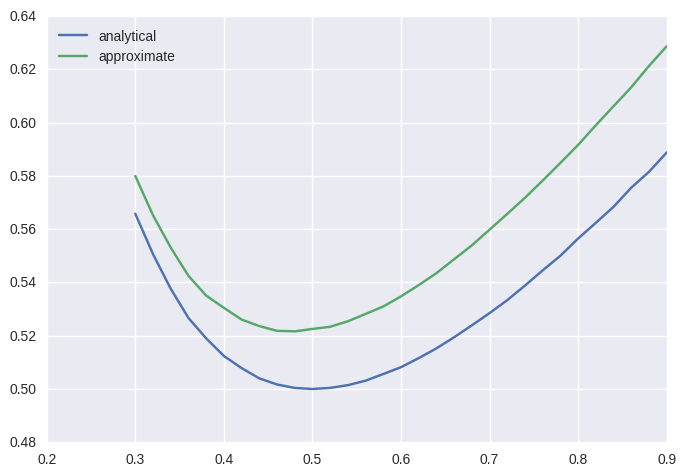

In [12]:
plt.plot(df_analytical["alpha"], df_analytical["energy"], label="analytical")
plt.plot(df_approximate["alpha"], df_approximate["energy"], label="approximate")
plt.legend(loc="best")
plt.show()

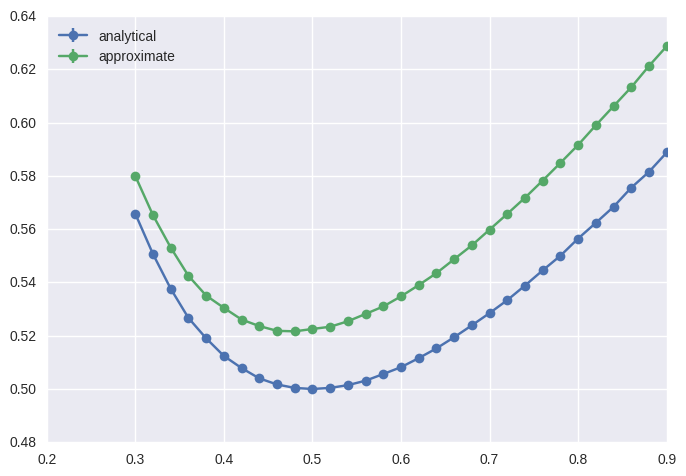

In [13]:
plt.errorbar(
    df_analytical["alpha"], df_analytical["energy"],
    yerr=np.sqrt(df_analytical["variance"])/np.sqrt(num_samples),
    label="analytical", fmt="o-")
plt.errorbar(
    df_approximate["alpha"], df_approximate["energy"],
    yerr=np.sqrt(df_approximate["variance"])/np.sqrt(num_samples),
    label="approximate", fmt="o-")
plt.legend(loc="best")
plt.show()

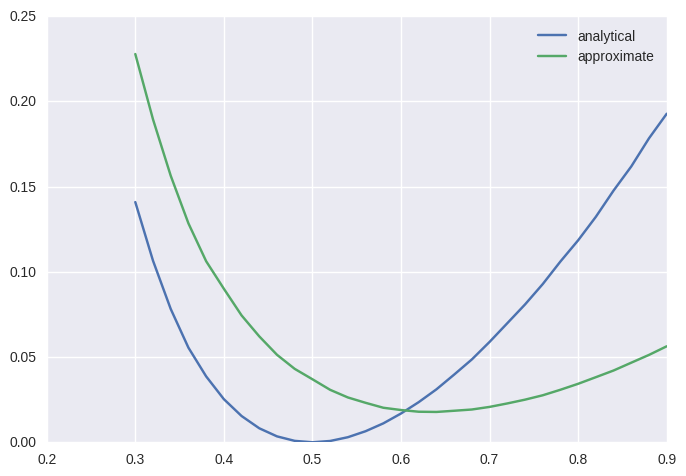

In [14]:
plt.plot(
    df_analytical["alpha"], df_analytical["variance"]/num_particles,
    label="analytical")
plt.plot(
    df_approximate["alpha"], df_approximate["variance"]/num_particles,
    label="approximate")
plt.legend(loc="best")
plt.show()

In [15]:
display(df_analytical)

,acceptance,alpha,energy,variance
0,0.601669,0.30,0.565804,0.140885
1,0.591254,0.32,0.550632,0.106493
2,0.581295,0.34,0.537639,0.078187
3,0.571146,0.36,0.526671,0.055473
4,0.562183,0.38,0.519023,0.038641
5,0.553075,0.40,0.512413,0.025283
6,0.545030,0.42,0.507852,0.015401
7,0.536616,0.44,0.503990,0.008202
8,0.528762,0.46,0.501704,0.003463
9,0.521256,0.48,0.500404,0.000832


In [16]:
display(df_approximate)

,acceptance,alpha,energy,variance
0,0.601939,0.30,0.579955,0.227717
1,0.591091,0.32,0.565224,0.189388
2,0.581046,0.34,0.553092,0.156338
3,0.571190,0.36,0.542479,0.128389
4,0.562271,0.38,0.535071,0.106192
5,0.553313,0.40,0.530459,0.090043
6,0.544554,0.42,0.526066,0.074405
7,0.536812,0.44,0.523622,0.062103
8,0.528740,0.46,0.521836,0.051305
9,0.521084,0.48,0.521640,0.043052


In [17]:
def exact_energy(alpha, omega, mass, num_particles, num_dimensions):
    first_term = hbar**2*num_dimensions*alpha*num_particles/float(mass)
    second_term = 0.5*mass*omega**2*num_particles*(1.0/(4.0*alpha))*num_dimensions
    third_term = -2*hbar**2*alpha**2*num_particles/float(mass)*(1.0/(4.0*alpha))*num_dimensions

    return first_term + second_term + third_term

In [18]:
energy_exact = np.zeros(num_alphas)

for i in range(num_alphas):
    energy_exact[i] = exact_energy(
        alphas[i, 0], omega, mass, num_particles, num_dimensions)

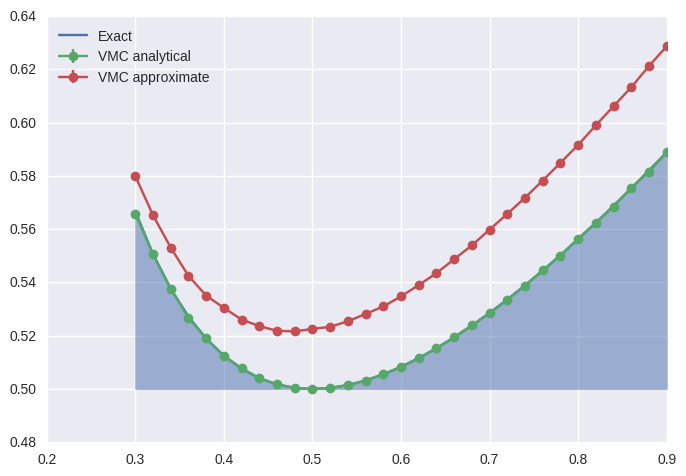

In [19]:
plt.plot(alphas.ravel(), energy_exact, label="Exact")
plt.fill_between(
    alphas.ravel(), min(energy_exact), energy_exact, alpha=0.5)
plt.errorbar(
    df_analytical["alpha"], df_analytical["energy"],
    yerr=np.sqrt(df_analytical["variance"])/np.sqrt(num_samples),
    label="VMC analytical", fmt="o-")
plt.errorbar(
    df_approximate["alpha"], df_approximate["energy"],
    yerr=np.sqrt(df_approximate["variance"])/np.sqrt(num_samples),
    label="VMC approximate", fmt="o-")
plt.legend(loc="best")
plt.show()